In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import os
import cv2
import numpy as np
import torch
from PIL import Image
from pytorch_lightning import seed_everything
from tqdm import tqdm

from cldm.model import create_model, load_state_dict
from dataset import PhotoSketchDataset
from inference import run_sampler
from share import *

/raid/lingo/grandg/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [4]:
dataset = PhotoSketchDataset(split="test", data_dir="./data")

In [5]:
example = dataset[0]
prompt = example["txt"]
sketch = cv2.imread(dataset.sketches[0])
# sketch = dataset.sketches[0]

a pair of shoes sitting on top of a sandy beach


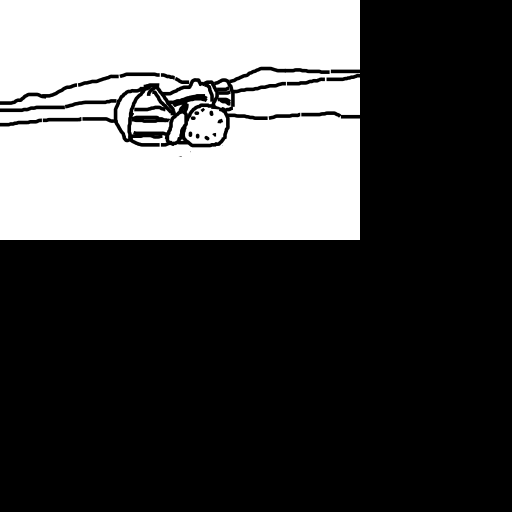

In [6]:
print(prompt)
Image.fromarray(cv2.cvtColor(sketch, cv2.COLOR_BGR2RGB), "RGB")

In [7]:
model = create_model('../models/cldm_v15.yaml').cpu()

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [../models/cldm_v15.yaml]


In [8]:
model.load_state_dict(load_state_dict("/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt", location='cuda'))
model = model.cuda()

Loaded state_dict from [/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt]


In [9]:
results = run_sampler(model, sketch, prompt, seed=42)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


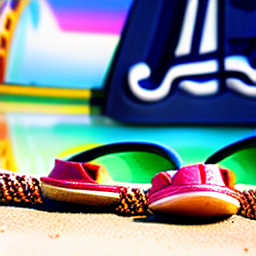

In [10]:
Image.fromarray(results[0], "RGB")

# Running inference on the whole test set

In [ ]:
RESOLUTION = 512
OUTPUT_DIR = f"photosketch_test_outputs_{RESOLUTION}/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for i in tqdm(range(len(dataset))):
    example = dataset[i]
    prompt = example["txt"]
    sketch = cv2.imread(dataset.sketches[i])
    results = run_sampler(model, sketch, prompt, image_resolution=RESOLUTION, seed=42, show_progress=False)
    
    image = Image.fromarray(results[0], "RGB")
    image.save(os.path.join(OUTPUT_DIR, f"image_{i:03d}.jpg"))

  0%|          | 0/500 [00:00<?, ?it/s]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  0%|          | 1/500 [00:05<42:49,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  0%|          | 2/500 [00:10<42:35,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|          | 3/500 [00:15<42:11,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|          | 4/500 [00:20<41:58,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|          | 5/500 [00:25<41:46,  5.06s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|          | 6/500 [00:30<41:43,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▏         | 7/500 [00:35<41:41,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 8/500 [00:40<41:33,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 9/500 [00:45<41:46,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 10/500 [00:50<41:38,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 11/500 [00:55<41:29,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|▏         | 12/500 [01:01<41:20,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 13/500 [01:06<41:17,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 14/500 [01:11<41:11,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 15/500 [01:16<41:11,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 16/500 [01:21<41:04,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|▎         | 17/500 [01:26<41:19,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|▎         | 18/500 [01:31<41:13,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 19/500 [01:36<41:01,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 20/500 [01:41<40:51,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 21/500 [01:47<40:51,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|▍         | 22/500 [01:52<40:47,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 23/500 [01:57<40:59,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|▍         | 24/500 [02:02<40:50,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|▌         | 25/500 [02:07<40:43,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|▌         | 26/500 [02:12<40:32,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|▌         | 27/500 [02:17<40:23,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 28/500 [02:23<40:15,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 29/500 [02:28<40:06,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 30/500 [02:33<40:02,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|▌         | 31/500 [02:38<40:04,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|▋         | 32/500 [02:43<40:02,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 33/500 [02:48<39:54,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 34/500 [02:53<39:43,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 35/500 [02:58<39:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 36/500 [03:03<39:26,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|▋         | 37/500 [03:08<39:17,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 38/500 [03:14<39:09,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 39/500 [03:19<39:04,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 40/500 [03:24<38:59,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 41/500 [03:29<38:53,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|▊         | 42/500 [03:34<38:51,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|▊         | 43/500 [03:39<38:46,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 44/500 [03:44<38:39,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 45/500 [03:49<38:39,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 46/500 [03:54<38:32,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|▉         | 47/500 [03:59<38:29,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 48/500 [04:04<38:22,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|▉         | 49/500 [04:10<38:15,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|█         | 50/500 [04:15<38:13,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|█         | 51/500 [04:20<38:09,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|█         | 52/500 [04:25<38:34,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 53/500 [04:30<38:16,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 54/500 [04:35<38:04,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 55/500 [04:40<37:57,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|█         | 56/500 [04:45<37:51,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|█▏        | 57/500 [04:51<37:47,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 58/500 [04:56<37:38,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 59/500 [05:01<37:32,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 60/500 [05:06<37:30,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 61/500 [05:11<37:22,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|█▏        | 62/500 [05:16<37:17,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 63/500 [05:21<37:17,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 64/500 [05:26<37:08,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 65/500 [05:31<37:01,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 66/500 [05:37<36:56,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|█▎        | 67/500 [05:42<36:49,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█▎        | 68/500 [05:47<36:40,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 69/500 [05:52<36:33,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 70/500 [05:57<36:26,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 71/500 [06:02<36:20,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█▍        | 72/500 [06:07<36:13,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 73/500 [06:12<36:08,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█▍        | 74/500 [06:17<36:04,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█▌        | 75/500 [06:22<35:58,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█▌        | 76/500 [06:27<35:53,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█▌        | 77/500 [06:32<35:49,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 78/500 [06:38<35:47,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 79/500 [06:43<35:42,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 80/500 [06:48<35:41,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█▌        | 81/500 [06:53<35:35,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█▋        | 82/500 [06:58<35:29,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 83/500 [07:03<35:21,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 84/500 [07:08<35:17,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 85/500 [07:13<35:15,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 86/500 [07:19<35:33,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|█▋        | 87/500 [07:24<35:25,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 88/500 [07:29<35:15,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 89/500 [07:34<35:04,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 90/500 [07:39<34:55,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 91/500 [07:44<35:00,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 18%|█▊        | 92/500 [07:49<34:50,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 19%|█▊        | 93/500 [07:54<34:41,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 94/500 [07:59<34:35,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 95/500 [08:05<34:29,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 96/500 [08:10<34:21,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 19%|█▉        | 97/500 [08:15<34:19,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 98/500 [08:20<34:17,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 20%|█▉        | 99/500 [08:25<34:07,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 100/500 [08:30<34:00,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 101/500 [08:35<34:00,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 20%|██        | 102/500 [08:40<33:51,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 103/500 [08:45<33:47,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 104/500 [08:50<33:43,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 105/500 [08:56<33:49,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 21%|██        | 106/500 [09:01<33:37,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 21%|██▏       | 107/500 [09:06<33:28,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 108/500 [09:11<33:20,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 109/500 [09:16<33:21,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 110/500 [09:21<33:16,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 111/500 [09:26<33:07,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 22%|██▏       | 112/500 [09:31<33:11,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 113/500 [09:37<33:01,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 114/500 [09:42<32:53,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 115/500 [09:47<32:45,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 116/500 [09:52<32:40,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 23%|██▎       | 117/500 [09:57<32:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 24%|██▎       | 118/500 [10:02<32:28,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 119/500 [10:07<32:26,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 120/500 [10:12<32:24,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 121/500 [10:17<32:16,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 24%|██▍       | 122/500 [10:23<32:08,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 123/500 [10:28<32:01,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 25%|██▍       | 124/500 [10:33<31:56,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 125/500 [10:38<32:03,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 126/500 [10:43<31:52,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 25%|██▌       | 127/500 [10:48<31:44,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 128/500 [10:53<31:37,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 129/500 [10:58<31:29,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 130/500 [11:03<31:25,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 26%|██▌       | 131/500 [11:08<31:27,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 26%|██▋       | 132/500 [11:14<31:19,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 133/500 [11:19<31:15,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 134/500 [11:24<31:09,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 135/500 [11:29<31:04,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 136/500 [11:34<30:57,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 27%|██▋       | 137/500 [11:39<30:49,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 138/500 [11:44<30:46,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 139/500 [11:49<30:44,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 140/500 [11:55<30:56,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 141/500 [12:00<30:50,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 28%|██▊       | 142/500 [12:05<30:38,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 29%|██▊       | 143/500 [12:10<30:30,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 144/500 [12:15<30:25,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 145/500 [12:20<30:17,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 146/500 [12:25<30:11,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 29%|██▉       | 147/500 [12:30<30:04,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 148/500 [12:35<29:59,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 30%|██▉       | 149/500 [12:41<29:50,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 150/500 [12:46<29:50,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 151/500 [12:51<29:43,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 30%|███       | 152/500 [12:56<29:34,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 153/500 [13:01<29:27,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 154/500 [13:06<29:20,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 155/500 [13:11<29:15,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 31%|███       | 156/500 [13:16<29:14,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 31%|███▏      | 157/500 [13:21<29:07,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 158/500 [13:26<29:01,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 159/500 [13:32<28:54,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 160/500 [13:37<28:56,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 161/500 [13:42<28:51,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 32%|███▏      | 162/500 [13:47<28:44,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 163/500 [13:52<28:38,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 164/500 [13:57<28:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 165/500 [14:02<28:28,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 166/500 [14:07<28:20,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 33%|███▎      | 167/500 [14:12<28:14,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 34%|███▎      | 168/500 [14:18<28:26,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 169/500 [14:23<28:16,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 170/500 [14:28<28:07,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 171/500 [14:33<27:58,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 34%|███▍      | 172/500 [14:38<27:51,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 173/500 [14:43<27:57,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 35%|███▍      | 174/500 [14:48<27:49,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 175/500 [14:53<27:42,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 176/500 [14:58<27:34,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 35%|███▌      | 177/500 [15:04<27:31,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 178/500 [15:09<27:25,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 179/500 [15:14<27:18,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 180/500 [15:19<27:11,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 36%|███▌      | 181/500 [15:24<27:05,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 36%|███▋      | 182/500 [15:29<26:58,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 183/500 [15:34<26:51,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 184/500 [15:39<26:45,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 185/500 [15:44<26:39,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 186/500 [15:49<26:34,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 37%|███▋      | 187/500 [15:54<26:28,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 188/500 [15:59<26:22,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 189/500 [16:04<26:18,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 190/500 [16:10<26:16,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 191/500 [16:15<26:09,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 38%|███▊      | 192/500 [16:20<26:03,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 39%|███▊      | 193/500 [16:25<25:59,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 194/500 [16:30<25:56,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 195/500 [16:35<25:52,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 196/500 [16:40<25:56,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 39%|███▉      | 197/500 [16:45<25:55,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 198/500 [16:50<25:45,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 40%|███▉      | 199/500 [16:56<25:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 200/500 [17:01<25:29,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 201/500 [17:06<25:25,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 40%|████      | 202/500 [17:11<25:19,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 203/500 [17:16<25:11,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 204/500 [17:21<25:06,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 205/500 [17:26<25:00,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 41%|████      | 206/500 [17:31<24:54,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 41%|████▏     | 207/500 [17:36<24:49,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 208/500 [17:41<24:44,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 209/500 [17:46<24:39,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 210/500 [17:51<24:34,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 211/500 [17:57<24:29,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 42%|████▏     | 212/500 [18:02<24:23,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 213/500 [18:07<24:18,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 214/500 [18:12<24:14,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 215/500 [18:17<24:08,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 216/500 [18:22<24:02,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 43%|████▎     | 217/500 [18:27<23:57,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 44%|████▎     | 218/500 [18:32<23:51,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 219/500 [18:37<23:45,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 220/500 [18:42<23:40,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 221/500 [18:47<23:34,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 44%|████▍     | 222/500 [18:52<23:28,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 45%|████▍     | 223/500 [18:57<23:23,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 45%|████▍     | 224/500 [19:03<23:20,  5.07s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 45%|████▌     | 225/500 [19:08<23:15,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 45%|████▌     | 226/500 [19:13<23:10,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 45%|████▌     | 227/500 [19:18<23:06,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 228/500 [19:23<23:01,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 229/500 [19:28<22:55,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 230/500 [19:33<22:53,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 46%|████▌     | 231/500 [19:38<22:47,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 46%|████▋     | 232/500 [19:43<22:42,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 233/500 [19:48<22:37,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 234/500 [19:53<22:31,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 235/500 [19:58<22:26,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 236/500 [20:04<22:37,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 47%|████▋     | 237/500 [20:09<22:31,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 238/500 [20:14<22:23,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 239/500 [20:19<22:14,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 240/500 [20:24<22:07,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 241/500 [20:29<22:01,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 48%|████▊     | 242/500 [20:34<21:57,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 49%|████▊     | 243/500 [20:39<21:53,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 244/500 [20:45<21:46,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 245/500 [20:50<21:40,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 246/500 [20:55<21:33,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 49%|████▉     | 247/500 [21:00<21:28,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 50%|████▉     | 248/500 [21:05<21:23,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 50%|████▉     | 249/500 [21:10<21:21,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 50%|█████     | 250/500 [21:15<21:14,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 50%|█████     | 251/500 [21:20<21:07,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 50%|█████     | 252/500 [21:25<21:03,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 253/500 [21:30<20:56,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 254/500 [21:35<20:49,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 255/500 [21:41<20:47,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 51%|█████     | 256/500 [21:46<20:42,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 51%|█████▏    | 257/500 [21:51<20:36,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 258/500 [21:56<20:30,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 259/500 [22:01<20:24,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 260/500 [22:06<20:21,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 261/500 [22:11<20:17,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 52%|█████▏    | 262/500 [22:16<20:14,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 263/500 [22:21<20:09,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 264/500 [22:26<20:03,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 265/500 [22:31<19:56,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 266/500 [22:37<19:52,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 53%|█████▎    | 267/500 [22:42<19:46,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 54%|█████▎    | 268/500 [22:47<19:41,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 269/500 [22:52<19:42,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 270/500 [22:57<19:39,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 271/500 [23:02<19:31,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 54%|█████▍    | 272/500 [23:07<19:23,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 55%|█████▍    | 273/500 [23:12<19:16,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 55%|█████▍    | 274/500 [23:17<19:14,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 55%|█████▌    | 275/500 [23:23<19:10,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 55%|█████▌    | 276/500 [23:28<19:11,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 55%|█████▌    | 277/500 [23:33<19:05,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 278/500 [23:38<18:59,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 279/500 [23:43<18:53,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 280/500 [23:48<18:46,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 56%|█████▌    | 281/500 [23:53<18:41,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 56%|█████▋    | 282/500 [23:58<18:33,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 283/500 [24:04<18:28,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 284/500 [24:09<18:22,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 285/500 [24:14<18:17,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 286/500 [24:19<18:12,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 57%|█████▋    | 287/500 [24:24<18:07,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 58%|█████▊    | 288/500 [24:29<18:01,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 58%|█████▊    | 289/500 [24:34<17:56,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 58%|█████▊    | 290/500 [24:39<17:50,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 58%|█████▊    | 291/500 [24:44<17:45,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 58%|█████▊    | 292/500 [24:49<17:40,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 59%|█████▊    | 293/500 [24:55<17:33,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 59%|█████▉    | 294/500 [25:00<17:28,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 59%|█████▉    | 295/500 [25:05<17:35,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 59%|█████▉    | 296/500 [25:10<17:30,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 59%|█████▉    | 297/500 [25:15<17:21,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 60%|█████▉    | 298/500 [25:20<17:14,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 60%|█████▉    | 299/500 [25:25<17:08,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 60%|██████    | 300/500 [25:30<17:02,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 60%|██████    | 301/500 [25:36<16:58,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 60%|██████    | 302/500 [25:41<16:52,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 61%|██████    | 303/500 [25:46<16:46,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 61%|██████    | 304/500 [25:51<16:40,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 61%|██████    | 305/500 [25:56<16:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 61%|██████    | 306/500 [26:01<16:29,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 61%|██████▏   | 307/500 [26:06<16:24,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 62%|██████▏   | 308/500 [26:11<16:18,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 62%|██████▏   | 309/500 [26:16<16:15,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 62%|██████▏   | 310/500 [26:21<16:09,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 62%|██████▏   | 311/500 [26:27<16:06,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 62%|██████▏   | 312/500 [26:32<16:00,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 63%|██████▎   | 313/500 [26:37<15:54,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 63%|██████▎   | 314/500 [26:42<15:49,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 63%|██████▎   | 315/500 [26:47<15:45,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 63%|██████▎   | 316/500 [26:52<15:44,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 63%|██████▎   | 317/500 [26:57<15:36,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 64%|██████▎   | 318/500 [27:02<15:29,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 64%|██████▍   | 319/500 [27:07<15:23,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 64%|██████▍   | 320/500 [27:13<15:17,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 64%|██████▍   | 321/500 [27:18<15:11,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 64%|██████▍   | 322/500 [27:23<15:06,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 65%|██████▍   | 323/500 [27:28<15:03,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 65%|██████▍   | 324/500 [27:33<14:58,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 65%|██████▌   | 325/500 [27:38<14:52,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 65%|██████▌   | 326/500 [27:43<14:46,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 65%|██████▌   | 327/500 [27:48<14:41,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 66%|██████▌   | 328/500 [27:53<14:35,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 66%|██████▌   | 329/500 [27:58<14:30,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 66%|██████▌   | 330/500 [28:03<14:24,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 66%|██████▌   | 331/500 [28:09<14:19,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 66%|██████▋   | 332/500 [28:14<14:14,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 67%|██████▋   | 333/500 [28:19<14:09,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 67%|██████▋   | 334/500 [28:24<14:04,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 67%|██████▋   | 335/500 [28:29<13:58,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 67%|██████▋   | 336/500 [28:34<13:53,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 67%|██████▋   | 337/500 [28:39<13:48,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 68%|██████▊   | 338/500 [28:44<13:42,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 68%|██████▊   | 339/500 [28:49<13:38,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 68%|██████▊   | 340/500 [28:54<13:33,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 68%|██████▊   | 341/500 [28:59<13:32,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 68%|██████▊   | 342/500 [29:05<13:31,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 69%|██████▊   | 343/500 [29:10<13:29,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 69%|██████▉   | 344/500 [29:15<13:22,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 69%|██████▉   | 345/500 [29:20<13:14,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 69%|██████▉   | 346/500 [29:25<13:08,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 69%|██████▉   | 347/500 [29:30<13:02,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 70%|██████▉   | 348/500 [29:35<12:58,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 70%|██████▉   | 349/500 [29:41<12:58,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 70%|███████   | 350/500 [29:46<12:50,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 70%|███████   | 351/500 [29:51<12:43,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 70%|███████   | 352/500 [29:56<12:38,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 71%|███████   | 353/500 [30:01<12:31,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 71%|███████   | 354/500 [30:06<12:26,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 71%|███████   | 355/500 [30:11<12:21,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 71%|███████   | 356/500 [30:16<12:15,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 71%|███████▏  | 357/500 [30:21<12:09,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 72%|███████▏  | 358/500 [30:27<12:04,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 72%|███████▏  | 359/500 [30:32<11:58,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 72%|███████▏  | 360/500 [30:37<11:53,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 72%|███████▏  | 361/500 [30:42<11:48,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 72%|███████▏  | 362/500 [30:47<11:43,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 73%|███████▎  | 363/500 [30:52<11:37,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 73%|███████▎  | 364/500 [30:57<11:32,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 73%|███████▎  | 365/500 [31:02<11:28,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 73%|███████▎  | 366/500 [31:07<11:22,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 73%|███████▎  | 367/500 [31:12<11:17,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 74%|███████▎  | 368/500 [31:17<11:11,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 74%|███████▍  | 369/500 [31:23<11:06,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 74%|███████▍  | 370/500 [31:28<11:00,  5.08s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 74%|███████▍  | 371/500 [31:33<10:56,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 74%|███████▍  | 372/500 [31:38<10:51,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 75%|███████▍  | 373/500 [31:43<10:46,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 75%|███████▍  | 374/500 [31:48<10:41,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 75%|███████▌  | 375/500 [31:53<10:36,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 75%|███████▌  | 376/500 [31:58<10:34,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 75%|███████▌  | 377/500 [32:03<10:28,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 76%|███████▌  | 378/500 [32:08<10:23,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 76%|███████▌  | 379/500 [32:14<10:17,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 76%|███████▌  | 380/500 [32:19<10:12,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 76%|███████▌  | 381/500 [32:24<10:09,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 76%|███████▋  | 382/500 [32:29<10:03,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 77%|███████▋  | 383/500 [32:34<09:57,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 77%|███████▋  | 384/500 [32:39<09:51,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 77%|███████▋  | 385/500 [32:44<09:45,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 77%|███████▋  | 386/500 [32:49<09:40,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 77%|███████▋  | 387/500 [32:54<09:35,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 78%|███████▊  | 388/500 [32:59<09:30,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 78%|███████▊  | 389/500 [33:05<09:25,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 78%|███████▊  | 390/500 [33:10<09:19,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 78%|███████▊  | 391/500 [33:15<09:16,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 78%|███████▊  | 392/500 [33:20<09:12,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 79%|███████▊  | 393/500 [33:25<09:06,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 79%|███████▉  | 394/500 [33:30<09:03,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 79%|███████▉  | 395/500 [33:35<08:57,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 79%|███████▉  | 396/500 [33:40<08:51,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 79%|███████▉  | 397/500 [33:45<08:45,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 80%|███████▉  | 398/500 [33:51<08:40,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 80%|███████▉  | 399/500 [33:56<08:36,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 80%|████████  | 400/500 [34:01<08:30,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 80%|████████  | 401/500 [34:06<08:24,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 80%|████████  | 402/500 [34:11<08:19,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 81%|████████  | 403/500 [34:16<08:14,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 81%|████████  | 404/500 [34:21<08:09,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 81%|████████  | 405/500 [34:26<08:04,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 81%|████████  | 406/500 [34:31<08:00,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 81%|████████▏ | 407/500 [34:37<07:56,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 82%|████████▏ | 408/500 [34:42<07:51,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 82%|████████▏ | 409/500 [34:47<07:45,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 82%|████████▏ | 410/500 [34:52<07:39,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 82%|████████▏ | 411/500 [34:57<07:34,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 82%|████████▏ | 412/500 [35:02<07:29,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 83%|████████▎ | 413/500 [35:07<07:25,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 83%|████████▎ | 414/500 [35:12<07:22,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 83%|████████▎ | 415/500 [35:18<07:16,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 83%|████████▎ | 416/500 [35:23<07:10,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 83%|████████▎ | 417/500 [35:28<07:04,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 84%|████████▎ | 418/500 [35:33<06:58,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 84%|████████▍ | 419/500 [35:38<06:52,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 84%|████████▍ | 420/500 [35:43<06:48,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 84%|████████▍ | 421/500 [35:48<06:43,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 84%|████████▍ | 422/500 [35:53<06:37,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 85%|████████▍ | 423/500 [35:58<06:32,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 85%|████████▍ | 424/500 [36:03<06:26,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 85%|████████▌ | 425/500 [36:08<06:21,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 85%|████████▌ | 426/500 [36:14<06:17,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 85%|████████▌ | 427/500 [36:19<06:12,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 86%|████████▌ | 428/500 [36:24<06:06,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 86%|████████▌ | 429/500 [36:29<06:02,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 86%|████████▌ | 430/500 [36:34<05:56,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 86%|████████▌ | 431/500 [36:39<05:51,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 86%|████████▋ | 432/500 [36:44<05:46,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 87%|████████▋ | 433/500 [36:49<05:41,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 87%|████████▋ | 434/500 [36:54<05:35,  5.09s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 87%|████████▋ | 435/500 [36:59<05:32,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 87%|████████▋ | 436/500 [37:05<05:29,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 87%|████████▋ | 437/500 [37:10<05:23,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 88%|████████▊ | 438/500 [37:15<05:19,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 88%|████████▊ | 439/500 [37:20<05:13,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 88%|████████▊ | 440/500 [37:25<05:07,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 88%|████████▊ | 441/500 [37:30<05:01,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 88%|████████▊ | 442/500 [37:35<04:55,  5.10s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 89%|████████▊ | 443/500 [37:41<04:53,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 89%|████████▉ | 444/500 [37:46<04:47,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 89%|████████▉ | 445/500 [37:51<04:41,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 89%|████████▉ | 446/500 [37:56<04:35,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 89%|████████▉ | 447/500 [38:01<04:30,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 90%|████████▉ | 448/500 [38:06<04:25,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 90%|████████▉ | 449/500 [38:11<04:20,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 90%|█████████ | 450/500 [38:16<04:17,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 90%|█████████ | 451/500 [38:21<04:11,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 90%|█████████ | 452/500 [38:27<04:05,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps
